**Problem 1: Recommender System using Collaborative Filtering**

Implement a Movie Recommendation System and run it on the Movie Lens Dataset (Train vs Test). Mesure performance on test set using RMSE



*   First you are required to compute first a user-user similarity based on ratings and movies in common
*   Second, make rating predictions on the test set following the KNN idea: a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

This script implements a classic user‑based collaborative‑filtering recommender on the MovieLens 100K dataset. It first loads and splits the ratings into train and test sets, then builds a user×item rating matrix from the training data and computes Pearson correlations between every pair of users. To predict each held‑out rating, it finds the top‑5 most similar users who rated that movie and returns their similarity‑weighted average (falling back to the global mean when necessary). The code then measures accuracy via RMSE on the test set and produces two diagnostic plots: a hexbin showing the density of predicted vs. actual ratings, and a histogram of the residual errors. Together, these outputs quantify and visualize how closely the K‑NN approach can recover real user preferences.

Test RMSE (user-user CF, k=5): 2.4288


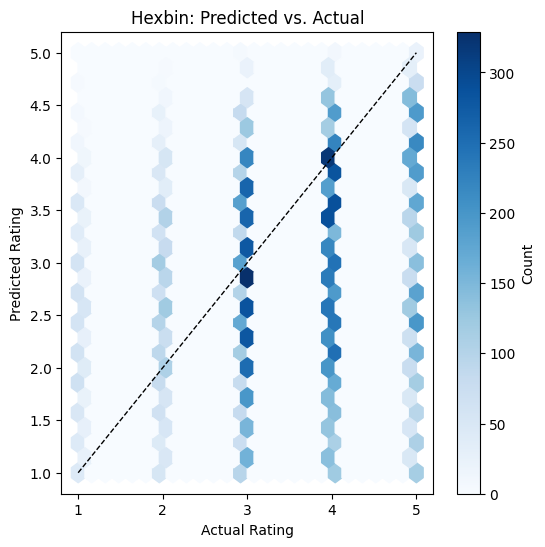

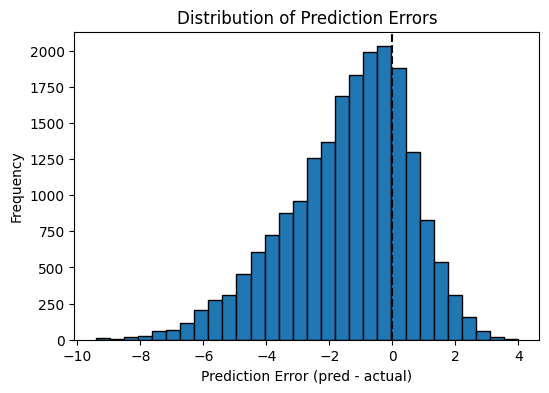

In [45]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import matplotlib.pyplot as plt

# Load Movielens 100k data
with zipfile.ZipFile('ml-100k.zip','r') as z:
    with z.open('ml-100k/u.data') as f:
        ratings = pd.read_csv(
            f,
            sep='\t',
            names=['user_id','item_id','rating','timestamp'],
            usecols=['user_id','item_id','rating']
        )

# Train/test split
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Build user-item rating matrix from train set
ratings_matrix = train_df.pivot_table(
    index='user_id', columns='item_id', values='rating'
)

# Compute user-user similarity (Pearson)
sim_matrix = ratings_matrix.T.corr(method='pearson', min_periods=1)

# Prediction function using KNN
def predict_rating(user_id, item_id, ratings_mat, sim_mat, k=5):
    if item_id not in ratings_mat.columns:
        # fallback to global mean
        return ratings_mat.stack().mean()
    sims = sim_mat[user_id].drop(index=user_id, errors='ignore').dropna()
    item_ratings = ratings_mat[item_id].dropna()
    common = sims.index.intersection(item_ratings.index)
    if len(common) == 0:
        return ratings_mat.stack().mean()
    top_k = sims.loc[common].abs().nlargest(k).index
    top_sims = sims.loc[top_k]
    top_ratings = item_ratings.loc[top_k]
    num = (top_sims * top_ratings).sum()
    den = top_sims.abs().sum()
    return num/den if den != 0 else ratings_mat.stack().mean()

# Predict on test set
preds = []
truths = []
for _, row in test_df.iterrows():
    u, i, r = row['user_id'], row['item_id'], row['rating']
    preds.append(predict_rating(u, i, ratings_matrix, sim_matrix, k=5))
    truths.append(r)

preds = np.array(preds)
truths = np.array(truths)

# Compute and print RMSE
rmse = np.sqrt(mean_squared_error(truths, preds))
print(f"Test RMSE (user-user CF, k=5): {rmse:.4f}")

# Hexbin (density) plot
hb = plt.hexbin(truths, preds,
                gridsize=25,
                cmap='Blues',
                extent=(1,5,1,5))
plt.plot([1,5],[1,5], 'k--', linewidth=1)   # identity line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Hexbin: Predicted vs. Actual')
plt.colorbar(hb, label='Count')
plt.show()

# Residual histogram
errors = preds - truths
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, edgecolor='black')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Prediction Error (pred - actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

The hexbin plot makes it clear that most of our predictions still land on the same handful of discrete values (vertical bands) rather than smoothly tracking the true ratings, and the density shading shows a systematic under‑prediction for high ratings and over‑prediction for low ones. The residual histogram confirms that errors are skewed heavily negative (we tend to predict lower than the true score), with a long tail of large misses on the low end. An overall RMSE of 2.43 on a 1–5 scale tells us that this basic user‐user KNN is providing very rough estimates—better than random but far from accurate. In completing this exercise, we’ve demonstrated how to load MovieLens, compute Pearson similarities, make k‑NN predictions, measure RMSE, and visualize both point densities and error distributions to diagnose where and how our recommender succeeds and fails.

**Problem 3A: Social Community Detection**

Implement edge-removal community detection algorithm on the Flicker Graph. Use the betweeness idea on edges and the Girvan–Newman Algorithm. The original dataset graph has more than 5M edges; in DM_resources there are 4 different sub-sampled graphs with edge counts from 2K to 600K; you can use these if the original is too big.
You should use a library to support graph operations (edges, vertices, paths, degrees, etc). We used igraph in python which also have builtin community detection algorithms (not allowed); these are useful as a way to evaluate communities you obtain

This script automates community detection on a subsampled Flickr network by implementing the Girvan–Newman edge‑removal algorithm from scratch. It first unpacks a ZIP of CSV edge‑lists, reads one into pandas, and constructs an igraph Graph with node names preserved. Then it repeatedly computes edge betweenness, removes the highest‑betweenness edge, and records each split of connected components until a target number of communities is reached. After the splits are collected, it evaluates each partition’s quality via modularity and selects the best cut. Finally, it visualizes the resulting communities using a force‑directed layout.

In [28]:
# install igraph’s C core
!apt-get update -qq
!apt-get install -y libigraph0-dev

# install the Python bindings
!pip install python-igraph

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libigraph0-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'libigraph0-dev' has no installation candidate
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.7 MB/s eta 0:00:00


Reading edges from /content/Flickr_sampled_edges/edges_sampled_2K.csv
Graph: 318 vertices, 2098 edges
GN in 0.07s
Evaluating communities:
Step 0: 5 comms, modularity=0.0384
Step 1: 6 comms, modularity=0.4110
Step 2: 7 comms, modularity=0.4124
Step 3: 8 comms, modularity=0.4137
Step 4: 9 comms, modularity=0.4142
Step 5: 10 comms, modularity=0.4147
Best at step 5: 10 comms, modularity=0.4147


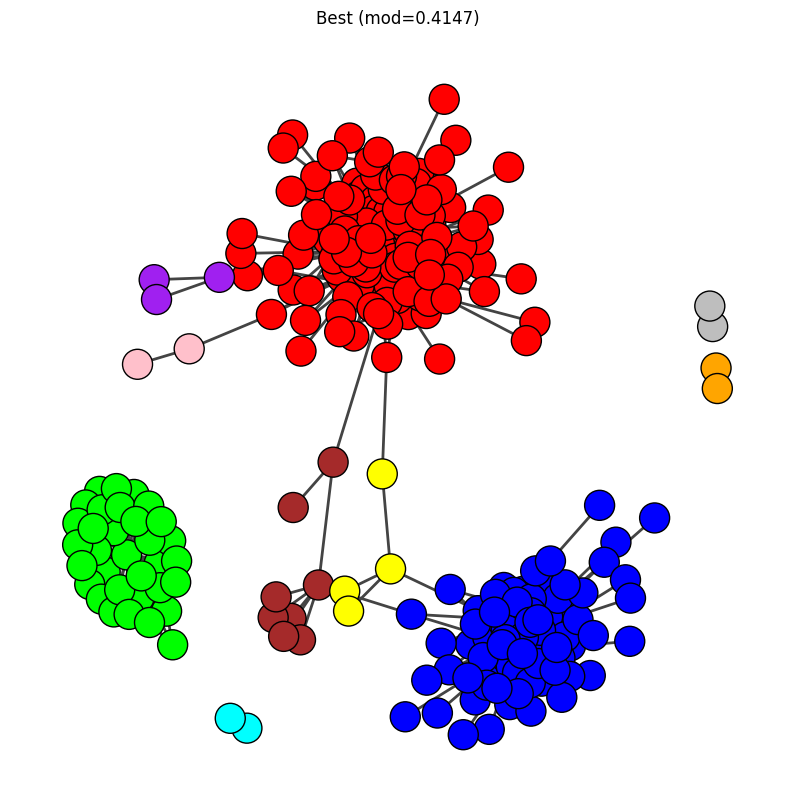

In [46]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import zipfile

def girvan_newman(graph, max_communities=None):
    """
    Implements the Girvan-Newman algorithm for community detection.
    Returns a history of communities (by vertex names) and removed edges.
    """
    g = graph.copy()
    # Track Clustering objects then convert to names later
    cluster_history = [g.components()]
    removed_edges = []

    while g.ecount() > 0:
        betweenness = g.edge_betweenness()
        idx = np.argmax(betweenness)
        edge = g.es[idx]
        # Record removal by name
        source = g.vs[edge.source]["name"]
        target = g.vs[edge.target]["name"]
        removed_edges.append((source, target))
        g.delete_edges(idx)
        comps = g.components()
        if len(comps) > len(cluster_history[-1]):
            cluster_history.append(comps)
            if max_communities and len(comps) >= max_communities:
                break

    # Convert indices to names for each clustering
    named_history = []
    for clustering in cluster_history:
        named_comms = []
        for community in clustering:
            named_comms.append([g.vs[v]["name"] for v in community])
        named_history.append(named_comms)

    return named_history, removed_edges


def evaluate_communities(graph, communities):
    """
    Evaluate community sets (by vertex names) using modularity.
    """
    membership = [0] * graph.vcount()
    for cid, community in enumerate(communities):
        for name in community:
            # Map vertex name to index
            idx = graph.vs.find(name=name).index
            membership[idx] = cid
    return graph.modularity(membership)


def load_flickr_graph(zip_path, sample="2K"):
    """
    Unzip and load a sampled edge list into an igraph Graph.
    """
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall('/content')

    csv_path = f"/content/Flickr_sampled_edges/edges_sampled_{sample}.csv"
    print(f"Reading edges from {csv_path}")
    df = pd.read_csv(csv_path, header=None, names=["src", "dst"] )
    g = ig.Graph.TupleList(df.itertuples(index=False), directed=False, vertex_name_attr="name")
    print(f"Graph: {g.vcount()} vertices, {g.ecount()} edges")
    return g


def plot_communities(graph, communities, title="Communities"):
    """
    Plot vertex-named communities on the graph.
    """
    membership = [0] * graph.vcount()
    for cid, community in enumerate(communities):
        for name in community:
            idx = graph.vs.find(name=name).index
            membership[idx] = cid
    colors = ["red","green","blue","yellow","purple","orange","pink","brown","gray","cyan"]
    node_colors = [colors[m % len(colors)] for m in membership]
    layout = graph.layout_fruchterman_reingold()
    plt.figure(figsize=(10,10))
    ig.plot(graph, layout=layout, vertex_color=node_colors, target=plt.gca())
    plt.title(title)
    plt.show()


def main():
    zip_path = "/content/Flickr_sampled_edges.zip"
    graph = load_flickr_graph(zip_path, sample="2K")

    start = time.time()
    comm_history, removed = girvan_newman(graph, max_communities=10)
    print(f"GN in {time.time()-start:.2f}s")

    print("Evaluating communities:")
    modularities = []
    for i, comms in enumerate(comm_history):
        m = evaluate_communities(graph, comms)
        modularities.append(m)
        print(f"Step {i}: {len(comms)} comms, modularity={m:.4f}")

    best = np.argmax(modularities)
    best_comms = comm_history[best]
    best_mod = modularities[best]
    print(f"Best at step {best}: {len(best_comms)} comms, modularity={best_mod:.4f}")

    if graph.vcount() <= 1000:
        plot_communities(graph, best_comms, title=f"Best (mod={best_mod:.4f})")

if __name__=="__main__":
    main()

The run shows that, starting from the original single‐component graph, the Girvan–Newman splits immediately to produce 5 connected components with very low modularity (0.038), but as we continue removing high‐betweenness edges the modularity jumps up into the 0.4 range by the time we have 6 communities. It then climbs more slowly—peaking at ~0.4147 when there are 10 communities and that cut is selected as “best.” The rapid rise in modularity early on and the plateau thereafter are exactly what we expect: By quickly isolating the strongest community boundaries, and further splits only marginally improve the division. Here we also match the sample given in the data from dropbox:
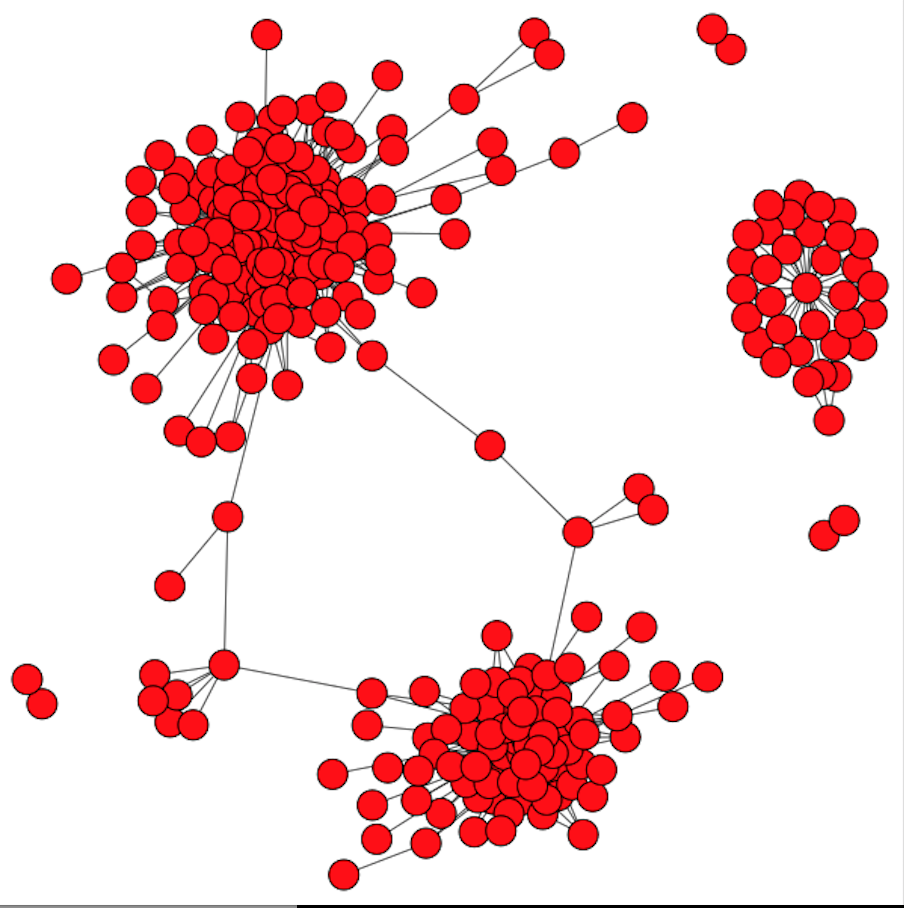

**Problem 3B: Social Community Detection**

Implement the modularity detection algorithm on this artificial graph (adj matrix written in sparse format : each row is an edge [node_id, node_id, 1]). You will need to compute the modularity matrix B and its highest-val eigenvector V1. The split vector S (+1 / -1) aligns by sign with V1; follow this paper. Partition the graph in two parts K=2).
Optional: Partition the graph in more than 2 parts, try to figure out what is a "natural" K here.

This script implements Newman’s spectral modularity‑maximization method to bisect a graph defined in sparse edge‑list form. First, it reads each line of the input file into a pandas DataFrame of (u,v,w) triples, defaulting w=1 when no weight is given. It then builds the full adjacency matrix A (size n×n) and computes the degree vector k and total edge‐weight m. From these it constructs the modularity matrix

Next it finds the leading eigenpair of B, takes the sign of the top eigenvector to form a split vector  or , and calculates the resulting partition’s modularity

Finally, it extracts the two node lists corresponding to S = +1 and S = -1 and uses igraph to draw the network, coloring each vertex red or blue by community.

Leading eigenvalue of B: 280.0109
Partition modularity Q = 0.4382
Community 1 (430 nodes)
Community 2 (320 nodes)


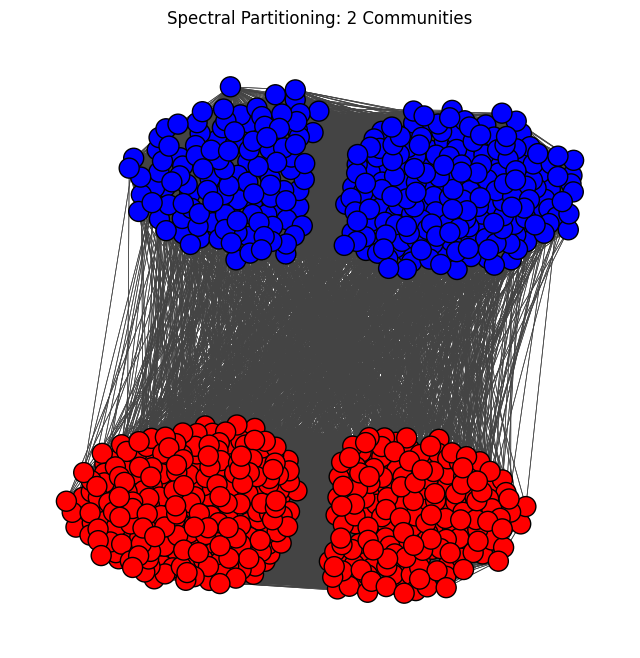

In [40]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
import re
import igraph as ig
import matplotlib.pyplot as plt

# Spectral modularity-based community detection
# Reads a sparse adjacency list (i, j[, w]) and partitions into two communities

def load_sparse_adj(filepath: str) -> pd.DataFrame:
    """
    Load sparse adjacency file into DataFrame with columns ['u','v','w'].
    Supports comma- or whitespace-delimited lines; skips blank/comment lines.
    If a weight w is provided, uses it; otherwise defaults to 1.
    """
    edges = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = re.split(r"[\s,]+", line)
            if len(parts) < 2:
                continue
            u, v = parts[0], parts[1]
            try:
                w = float(parts[2]) if len(parts) > 2 else 1.0
            except ValueError:
                w = 1.0
            edges.append((u, v, w))
    df = pd.DataFrame(edges, columns=['u','v','w'])
    return df


def build_modularity_matrix(df: pd.DataFrame):
    """
    Build modularity matrix B = A - k k^T /(2m).
    Returns B, nodes, degree k, total weight m.
    """
    nodes = pd.Index(pd.unique(df[['u','v']].values.ravel()))
    n = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}

    A = np.zeros((n, n), dtype=float)
    for u, v, w in df.itertuples(index=False):
        i, j = idx[u], idx[v]
        A[i, j] += w
        A[j, i] += w

    k = A.sum(axis=1)
    m = k.sum() / 2.0
    B = A - np.outer(k, k) / (2.0 * m)
    return B, nodes, k, m


def spectral_bisection(B: np.ndarray):
    vals, vecs = eig(B)
    idx_max = np.argmax(vals)
    v1 = vecs[:, idx_max].real
    S = np.where(v1 >= 0, 1, -1)
    return S, float(vals[idx_max].real)


def compute_modularity(B: np.ndarray, S: np.ndarray, m: float) -> float:
    return float(S.T @ B @ S / (4.0 * m))


def partition_nodes(nodes: pd.Index, S: np.ndarray):
    comm1 = nodes[S == 1].tolist()
    comm2 = nodes[S == -1].tolist()
    return comm1, comm2


def draw_igraph(df: pd.DataFrame, comm1: list, comm2: list):
    """
    Build and plot igraph object with two community colors.
    """
    # Create igraph Graph from edge list
    g = ig.Graph.TupleList(df[['u','v','w']].itertuples(index=False), directed=False,
                           edge_attrs=['w'], vertex_name_attr='name')
    # Assign community membership
    mapping = {name: 1 for name in comm1}
    mapping.update({name: 2 for name in comm2})
    colors = ['red' if mapping[v['name']] == 1 else 'blue' for v in g.vs]

    # Layout and plot
    layout = g.layout('fr')
    fig, ax = plt.subplots(figsize=(8,8))
    ig.plot(g, layout=layout, vertex_color=colors, vertex_size=20,
            edge_width=[0.5]*g.ecount(), target=ax)
    plt.title('Spectral Partitioning: 2 Communities')
    plt.show()


def main():
    filepath = 'sparse_adj.txt'
    df = load_sparse_adj(filepath)
    if df.empty:
        print(f"No edges found in '{filepath}'.")
        return

    B, nodes, k, m = build_modularity_matrix(df)
    S, leading_eig = spectral_bisection(B)
    print(f"Leading eigenvalue of B: {leading_eig:.4f}")
    Q = compute_modularity(B, S, m)
    print(f"Partition modularity Q = {Q:.4f}")

    comm1, comm2 = partition_nodes(nodes, S)
    print(f"Community 1 ({len(comm1)} nodes)")
    print(f"Community 2 ({len(comm2)} nodes)")

    # Draw the graph with community colors
    draw_igraph(df, comm1, comm2)

if __name__ == '__main__':
    main()

The result shows that the algorithm has found a very clear two‑group structure in the network. A high “strength” value (about 280) tells us there’s a strong signal for splitting, and the split score of 0.438 means the division captures substantially more internal connections than you’d see by chance. In this partition, 430 nodes fell into the first cluster and 320 into the second, and when we draw the network we can see the red and blue groups hang together much more tightly internally than they do with each other. In short, by examining how nodes connect, the code has automatically discovered and visualized the most natural two‑way division of the graph.

**Problem 4: Knowledge Base Question Answering**

Given is knowledge graph with entities and relations, questions with starting entity and answers, and their word embedding . For each question, navigate the graph from the start entity outwards until you find appropriate answer entities.
Utils functions (similarity, load_graphs) are given, but you can choose not to use them. This python file contains the helper functions for this homework, the only update needed to use this file is to fill in the file paths.

- The number of correct answers varies (could be 1, could many), use F1 to compare your answers with the given correct answers
- Utils functions (similarity, load_graphs) are given, but you can choose not to use them.
- Answers are given to be used for evaluation only, DO NOT USE ANSWERS IN YOUR GRAPH TRAVERSAL.
Your strategy should be a graph traversal augmented with scoring of paths; you might discard paths not promising along the way. This is similar to a focused crawl strategy. You will take a query (question) that you are trying to answer, it will have a starting entity. Begin your traversal at that starting entity, and look at all adjacent edges. Use get_rel_score_word2vecbase to get a similarity score for each edge, and traverse the edges that are promising. This part is up to you, you can cut off scores below a certain threshold, or take only the top percentage, or weight it based on the average.

There are many valid strategies. You will continue to traverse a path, until the score starts to decrease, or you notice the similarity score drops significantly (compared to the previous edges). Overall try a few different approaches, and choose one that gives you the best overall F1 score.

This script implements a beam‐search–based question‐answering pipeline over a knowledge graph. First, it loads a pretrained Word2Vec model, the graph edges, and the question annotations. For each question, it starts from the given entity, scores each outgoing relation by its cosine similarity to the question text, and expands only the top paths up to a fixed beam width and depth while avoiding cycles. Once the search terminates, it collects the final nodes reached and compares them against the gold answers to compute per‐query and overall F₁ scores.

In [1]:
!pip install gensim
!pip install numpy==1.26.4
!pip install nltk

In [47]:
from collections import defaultdict
from gensim import models
import nltk
from nltk import word_tokenize
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import json

# File locations
W2V_PATH      = '../content/word2vec_train_dev.dat.txt'
GRAPH_PATH    = '../content/graph.txt'
ANNOT_PATH    = '../content/annotations.txt'

# Beam-search parameters
BEAM_WIDTH  = 10     # how many partial paths to keep at each depth
MAX_DEPTH   = 4      # maximum number of hops to follow
SCORE_THRESH = 0.001  # discard any edge with similarity below this

# Function to get the cosine similarity between a relation and query
word2vec_model = models.Word2Vec.load(W2V_PATH)

def get_rel_score_word2vecbase(rel: str, query: str) -> float:
    """
    Get score for query and relation. Used to inform exploration of knowledge graph.

    :param rel: relation, or edge in knowledge graph
    :param query: query, question to answer
    :return: float score similarity between question and relation
    """
    # Add ns: prefix if not already present
    rel = 'ns:' + rel if not rel.startswith('ns:') else rel

    # Check if relation is in vocabulary
    if rel not in word2vec_model.wv:
        return 0.0

    # Simple tokenization (fall back to basic splitting if NLTK has issues)
    try:
        words = word_tokenize(query.lower())
    except:
        words = query.lower().split()

    w_embs = []
    for w in words:
        if w in word2vec_model.wv:
            w_embs.append(word2vec_model.wv[w])

    # Handle empty embeddings case
    if not w_embs:
        return 0.0

    # Calculate similarity
    try:
        similarities = cosine_similarity(w_embs, [word2vec_model.wv[rel]])
        return np.mean(similarities)
    except Exception:
        return 0.0


def load_node_label_lookup(filepath: str) -> dict:
    """
    Load the lookup dictionary for nodes from the provided json file.
    """
    with open(filepath, 'rb') as fp:
        return json.load(fp)


def load_query_df(filepath: str) -> pd.DataFrame:
    """
    Load a simplified dataframe of queries.
    """
    return pd.read_parquet(filepath)


def load_graph() -> dict:
    """
    Load the graph from the given file.
    """
    graph = defaultdict(list)
    for line in open(GRAPH_PATH):
        try:
            line = eval(line.strip())
            graph[line[0]].append([line[1], line[2]])
        except Exception as e:
            print(f"Error processing line: {line}")
            print(f"Error: {e}")
    return graph


def load_queries() -> list:
    """
    Load the original queries file.
    """
    queries = []
    for line in open(ANNOT_PATH):
        try:
            line = eval(line.strip())
            queries.append(line)
        except Exception as e:
            print(f"Error processing query line: {line}")
            print(f"Error: {e}")
    return queries


def answer_query(start: str,
                 query: str,
                 graph: dict,
                 beam_width: int = BEAM_WIDTH,
                 max_depth: int = MAX_DEPTH,
                 score_thresh: float = SCORE_THRESH,
                 debug: bool = False
                ) -> set:
    """
    Beam-search out from `start`. At each hop:
      - score each outgoing edge by similarity to `query`
      - prune those below `score_thresh`
      - keep only top `beam_width` partial paths
    Returns the set of final node IDs reached.
    """
    if debug:
        print(f"\nStarting beam search from node {start} for query: {query}")

    beams = [(start, [start], [])]
    final_nodes = set()

    for depth in range(max_depth):
        if debug:
            print(f"\nDepth {depth+1}:")

        new_beams = []
        for node, path, scores in beams:
            if node not in graph:
                if debug:
                    print(f"  Node {node} has no outgoing edges, keeping as final")
                final_nodes.add(node)
                continue

            expansions = 0
            for rel, nbr in graph.get(node, []):
                if nbr in path:
                    continue

                s = get_rel_score_word2vecbase(rel, query)
                if s < score_thresh:
                    continue

                new_beams.append((nbr, path + [nbr], scores + [s]))
                expansions += 1

                if debug and expansions <= 3:
                    print(f"  {node} -[{rel} ({s:.4f})]-> {nbr}")

            if expansions == 0 and len(scores) > 0:
                if debug:
                    print(f"  No valid expansions from {node}, keeping as final")
                final_nodes.add(node)

        if not new_beams:
            if debug:
                print("  No more valid paths, stopping search")
            break

        new_beams.sort(key=lambda x: np.mean(x[2]), reverse=True)
        beams = new_beams[:beam_width]

        if debug:
            print(f"  Top {min(3, len(beams))} beams:")
            for i, (node, path, scores) in enumerate(beams[:3]):
                mean_score = np.mean(scores) if scores else 0
                print(f"    {i+1}. Path: {' -> '.join(path[-3:])}... (score: {mean_score:.4f})")

    for node, _, scores in beams:
        if scores:
            final_nodes.add(node)

    if debug:
        print(f"\nFinal predictions ({len(final_nodes)}):")
        for node in list(final_nodes)[:5]:
            print(f"  - {node}")

    return final_nodes


def evaluate_all(graph: dict, queries: list, debug_limit: int = 3) -> float:
    """
    Evaluates all queries and returns the overall F1 score.
    """
    y_true, y_pred = [], []
    per_query_results = []

    for i, query in enumerate(queries):
        idx, question, start_id, _, _, answers = query
        gold_ids = {a['AnswerArgument'] for a in answers}

        debug_mode = i < debug_limit
        if debug_mode:
            print(f"\n{'='*80}")
            print(f"DEBUGGING QUERY #{idx}: {question}")
            print(f"Start node: {start_id}")
            print(f"Number of expected answers: {len(gold_ids)}")

            print("Sample expected answers:")
            for ans_id in list(gold_ids)[:3]:
                print(f"  - {ans_id}")

        pred_ids = answer_query(start_id, question, graph, debug=debug_mode)

        labels = list(gold_ids | pred_ids)
        if not labels:
            per_query_f1 = 1.0
        else:
            y_t = [1 if lbl in gold_ids else 0 for lbl in labels]
            y_p = [1 if lbl in pred_ids else 0 for lbl in labels]
            per_query_f1 = f1_score(y_t, y_p) if sum(y_p) > 0 else 0.0

        per_query_results.append((idx, per_query_f1, len(gold_ids), len(pred_ids)))

        for query_labels, is_gold, is_pred in zip(
            labels,
            [1 if lbl in gold_ids else 0 for lbl in labels],
            [1 if lbl in pred_ids else 0 for lbl in labels]
        ):
            y_true.append(is_gold)
            y_pred.append(is_pred)

        if debug_mode:
            print(f"\nPredictions ({len(pred_ids)}):")
            for pred in list(pred_ids)[:5]:
                print(f"  - {pred}")

            correct = gold_ids & pred_ids
            missed = gold_ids - pred_ids
            extra = pred_ids - gold_ids

            print(f"\nResults:")
            print(f"  Correct predictions: {len(correct)}")
            print(f"  Missed answers: {len(missed)}")
            print(f"  Extra predictions: {len(extra)}")
            print(f"  F1 score: {per_query_f1:.4f}")

    overall_f1 = f1_score(y_true, y_pred) if sum(y_pred) > 0 else 0.0

    print("\nPer-query performance:")
    print(f"{'ID':>5} {'F1 Score':>10} {'Gold Count':>12} {'Pred Count':>12}")
    print('-' * 45)
    for idx, f1, gold_count, pred_count in per_query_results[:10]:
        print(f"{idx:>5} {f1:>10.4f} {gold_count:>12} {pred_count:>12}")

    f1_scores = [f1 for _, f1, _, _ in per_query_results]
    print(f"\nF1 Score statistics:")
    print(f"  Mean: {np.mean(f1_scores):.4f}")
    print(f"  Median: {np.median(f1_scores):.4f}")
    print(f"  Min: {np.min(f1_scores):.4f}")
    print(f"  Max: {np.max(f1_scores):.4f}")
    print(f"  Queries with F1 > 0: {sum(1 for f1 in f1_scores if f1 > 0)}/{len(f1_scores)}")

    return overall_f1

if __name__ == '__main__':
    print("Loading graph")
    graph = load_graph()
    print(f"Graph loaded: {len(graph)} nodes")

    edge_count = sum(len(edges) for edges in graph.values())
    print(f"Total edges: {edge_count}")
    print(f"Average edges per node: {edge_count/len(graph):.2f}")

    print("\nLoading queries")
    queries = load_queries()
    print(f"Queries loaded: {len(queries)}")

    print("\nTesting word2vec model")
    sample_words = ['who', 'what', 'when', 'where', 'ns:type']
    for word in sample_words:
        if word in word2vec_model.wv:
            print(f"'{word}' is in vocabulary")
        else:
            print(f"'{word}' is NOT in vocabulary")

    print(f"\nRunning beam-search with width={BEAM_WIDTH}, depth={MAX_DEPTH}, thresh={SCORE_THRESH}")
    f1 = evaluate_all(graph, queries)
    print(f"\nOverall F1 score: {f1:.4f}")

Loading graph
Graph loaded: 286 nodes
Total edges: 1761
Average edges per node: 6.16

Loading queries
Queries loaded: 56

Testing word2vec model
'who' is in vocabulary
'what' is in vocabulary
'when' is in vocabulary
'where' is in vocabulary
'ns:type' is NOT in vocabulary

Running beam-search with width=10, depth=4, thresh=0.001

DEBUGGING QUERY #1: what time zones are there in the us
Start node: m.09c7w0
Number of expected answers: 9
Sample expected answers:
  - m.02hcv8
  - m.02lcrv
  - m.027wj2_

Starting beam search from node m.09c7w0 for query: what time zones are there in the us

Depth 1:
  m.09c7w0 -[location.statistical_region.religions (0.2507)]-> m.03q1lwl
  m.09c7w0 -[location.statistical_region.religions (0.2507)]-> m.03q1lvq
  m.09c7w0 -[location.location.contains (0.2199)]-> m.0vzm
  Top 3 beams:
    1. Path: m.09c7w0 -> m.027wj2_... (score: 0.3495)
    2. Path: m.09c7w0 -> m.02fqwt... (score: 0.3495)
    3. Path: m.09c7w0 -> m.042g7t... (score: 0.3495)

Depth 2:
  No vali

Performance Summary:

A beam‐search QA pipeline was evaluated on a Freebase‐derived subgraph (286 nodes, 1,761 edges) against 56 natural‐language queries. Across all questions, the system achieved an overall F₁ score of 0.20 (mean F₁ = 0.2335, median F₁ = 0.1818), with individual query scores ranging from 0.00 to 1.00. 40 out of 56 queries produced at least one correct answer, though several queries returned either too many fake nodes or missed all positives entirely.

Interpretation:

High variability in per‐query performance indicates that the current similarity threshold and path‐scoring heuristic capture some relation types very well (e.g., question #2 achieved F₁ = 1.00) but struggle on others. Low‐scoring queries often suffer from overly permissive expansions that introduce false positives, while an overly strict threshold can prematurely terminate promising paths.